Trial 30 Complete [00h 00m 33s]
val_loss: 22.180729866027832

Best val_loss So Far: 3.4035940170288086
Total elapsed time: 00h 15m 39s
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAE: 1.2939241882668264, MSE: 3.2140191712442387


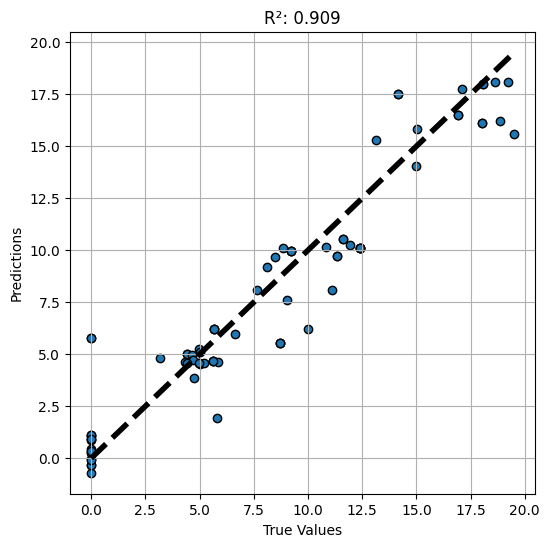

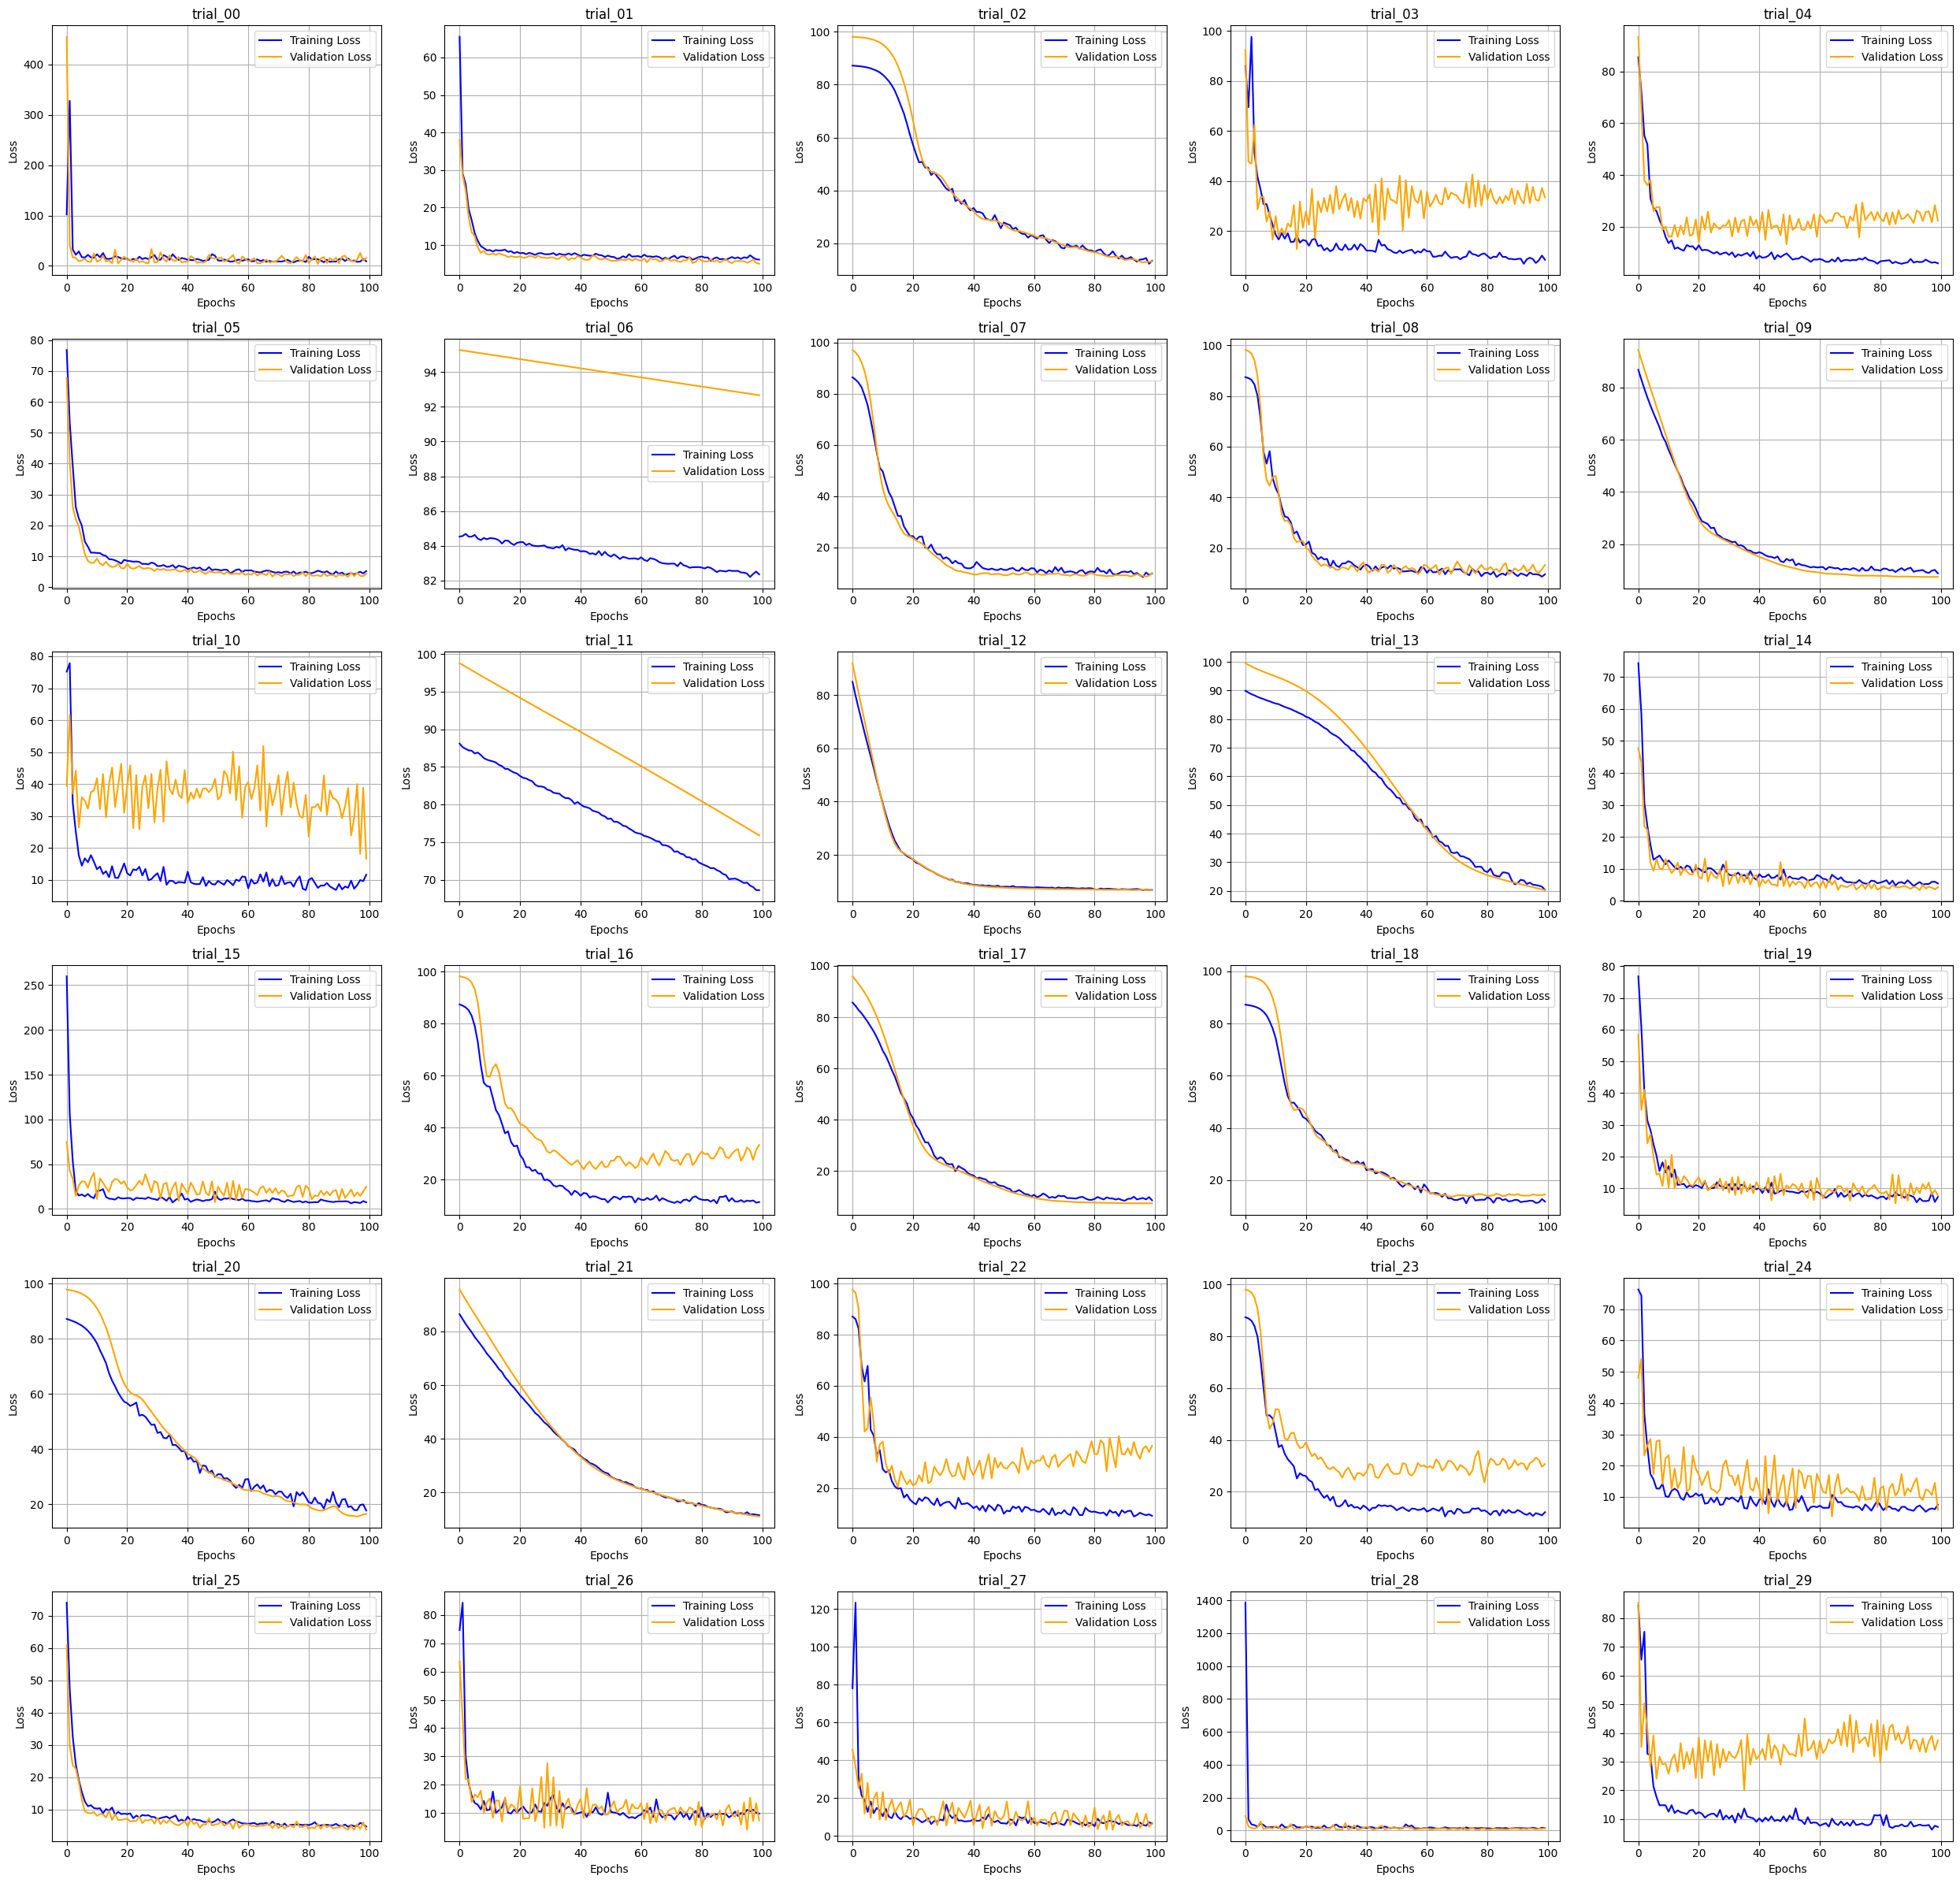

In [4]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from keras_tuner import BayesianOptimization
from tensorflow.data.experimental import AUTOTUNE
import matplotlib.pyplot as plt
import numpy as np
import math
import shutil  # 导入 shutil 模块
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 读取数据
X_train_scaled = pd.read_csv('X_train_scaled.csv')
y_train = pd.read_csv('y_train.csv').values[:, 0].squeeze()  # 选择第一列作为目标变量
X_test_scaled = pd.read_csv('X_test_scaled.csv')
y_test = pd.read_csv('y_test.csv').values[:, 0].squeeze()  # 同样选择第一列

# 启用全局混合精度策略
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# 准备数据集的函数
def create_dataset(X_data, y_data, batch_size=64):
    return tf.data.Dataset.from_tensor_slices((X_data, y_data)).batch(batch_size).prefetch(AUTOTUNE)

# 创建训练集和验证集
dataset_train = create_dataset(X_train_scaled, y_train)
dataset_val = create_dataset(X_test_scaled, y_test)

# 定义模型构建函数
def build_model(hp):
    model = keras.Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    for i in range(hp.Int('num_layers', 1, 15)):  # 最多15层
        # L1 和 L2 正则化参数动态调整
        l1_param = hp.Float(f'l1_{i}', min_value=0.0, max_value=1e-5, step=1e-6)
        l2_param = hp.Float(f'l2_{i}', min_value=0.0, max_value=1e-5, step=1e-6)

        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=1024, step=32),
                        activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_param, l2=l2_param)))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.06, max_value=0.5, step=0.02)))

    model.add(Dense(1, dtype='float32'))
    optimizer = AdamW(learning_rate=hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log'), clipnorm=1.0)  # 添加梯度剪裁
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')

    return model

# 定义回调函数用于记录和保存损失
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self, trial_dir):
        super().__init__()
        self.trial_dir = trial_dir
        self.losses = []
        self.val_losses = []

    # 每个 epoch 结束后记录训练损失和验证损失
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - Loss: {logs.get('loss')}, Val Loss: {logs.get('val_loss')}")
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.save_losses()

    # 保存损失值为 CSV 文件
    def save_losses(self):
        losses_file = os.path.join(self.trial_dir, 'losses.csv')
        val_losses_file = os.path.join(self.trial_dir, 'val_losses.csv')
        np.savetxt(losses_file, self.losses, delimiter=",")
        np.savetxt(val_losses_file, self.val_losses, delimiter=",")
        print(f"Saved losses to {losses_file} and {val_losses_file}")

# 自定义 tuner 类，用于传递 LossHistory 回调并根据试验结果调整超参数
class AdaptiveTuner(BayesianOptimization):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trial_results = []  # 存储每个试验的结果

    # 在每个 trial 中运行模型
    def run_trial(self, trial, *args, **kwargs):
        trial_id = trial.trial_id
        trial_dir = os.path.join(self.directory, self.project_name, f'trial_{trial_id}')
        os.makedirs(trial_dir, exist_ok=True)

        # 使用 LossHistory 回调记录每个 trial 的损失
        history = LossHistory(trial_dir)
        callbacks = [history]

        # 添加 ModelCheckpoint 回调，保存验证损失最小的模型
        model_checkpoint = ModelCheckpoint(filepath=os.path.join(trial_dir, f'trial_{trial_id}_MLP_best_model.keras'),
                                           monitor='val_loss', save_best_only=True)
        callbacks.append(model_checkpoint)

        # 传递回调
        kwargs['callbacks'] = callbacks
        result = super().run_trial(trial, *args, **kwargs)

        # 记录 trial 的验证损失
        if history.val_losses:
            self.trial_results.append((trial, history.val_losses[-1]))
        else:
            self.trial_results.append((trial, None))  # 如果验证损失为空，记录为 None

        return result

# 回调函数
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, min_lr=1e-6)
]

# 超参数搜索
tuner = AdaptiveTuner(
    build_model,
    objective='val_loss',  # 优化目标是验证损失
    max_trials=30,
    executions_per_trial=2,
    directory='my_dir',
    project_name='optimized_single_output_regression',
    overwrite=True
)

# 搜索超参数
tuner.search(dataset_train, epochs=100, validation_data=dataset_val, callbacks=callbacks)

# 找到最佳 trial
project_dir = os.path.join('my_dir', 'optimized_single_output_regression')

trial_dirs = [d for d in os.listdir(project_dir) if d.startswith('trial_')]
trial_dirs.sort(key=lambda x: int(x.split('_')[1]))

best_val_loss = float('inf')
best_trial_id = None

# 遍历所有 trial 文件夹，找出验证损失最低的 trial
for trial_dir in trial_dirs:
    val_losses_file = os.path.join(project_dir, f'{trial_dir}/val_losses.csv')
    if os.path.exists(val_losses_file):
        val_losses = np.loadtxt(val_losses_file, delimiter=",")
        if len(val_losses) > 0:
            min_val_loss = np.min(val_losses)
            if min_val_loss < best_val_loss:
                best_val_loss = min_val_loss
                best_trial_id = trial_dir.split('_')[1]

# 检查找到的最佳 trial 是否存在对应的模型文件
if best_trial_id is not None:
    best_model_path = os.path.join(project_dir, f'trial_{best_trial_id}', f'trial_{best_trial_id}_MLP_best_model.keras')

    if os.path.exists(best_model_path):
        # 保存最佳模型为 final_best_MLP_model.keras（使用复制而不是移动）
        final_model_path = 'final_best_MLP_model.keras'
        shutil.copy(best_model_path, final_model_path)  # 使用 shutil.copy 复制文件

        # 加载最佳模型
        best_model = keras.models.load_model(final_model_path)

        # 计算 MAE 和 MSE
        y_pred = best_model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        print(f'MAE: {mae}, MSE: {mse}')

        # 绘制 R² 图
        r2 = r2_score(y_test, y_pred)
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
        plt.title(f'R²: {r2:.3f}')
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.grid(True)
        plt.show()
    else:
        print(f"模型文件不存在: {best_model_path}")
else:
    print("未找到最佳 trial 的模型文件。")

# 绘制每个 trial 的训练损失和验证损失曲线
def plot_trials_loss_data(trial_dirs, project_dir):
    num_trials = len(trial_dirs)
    if num_trials == 0:
        print("No trials to plot.")
        return

    cols = 5
    rows = math.ceil(num_trials / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten() if rows > 1 else [axes]

    for trial_idx in range(num_trials):
        if trial_idx < num_trials:
            trial_dir = trial_dirs[trial_idx]
            losses_file = os.path.join(project_dir, trial_dir, 'losses.csv')
            val_losses_file = os.path.join(project_dir, trial_dir, 'val_losses.csv')
            
            if os.path.exists(losses_file) and os.path.exists(val_losses_file):
                losses = np.loadtxt(losses_file, delimiter=",")
                val_losses = np.loadtxt(val_losses_file, delimiter=",")
                
                axes[trial_idx].plot(losses, label='Training Loss', color='blue')
                axes[trial_idx].plot(val_losses, label='Validation Loss', color='orange')
                axes[trial_idx].set_title(trial_dir)
                axes[trial_idx].set_xlabel('Epochs')
                axes[trial_idx].set_ylabel('Loss')
                axes[trial_idx].legend()
                axes[trial_idx].grid(True)
            else:
                axes[trial_idx].set_title(trial_dir)
                axes[trial_idx].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')
                axes[trial_idx].axis('off')

    plt.tight_layout()
    plt.show()

# 绘制所有 trial 的损失数据
plot_trials_loss_data(trial_dirs, project_dir)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


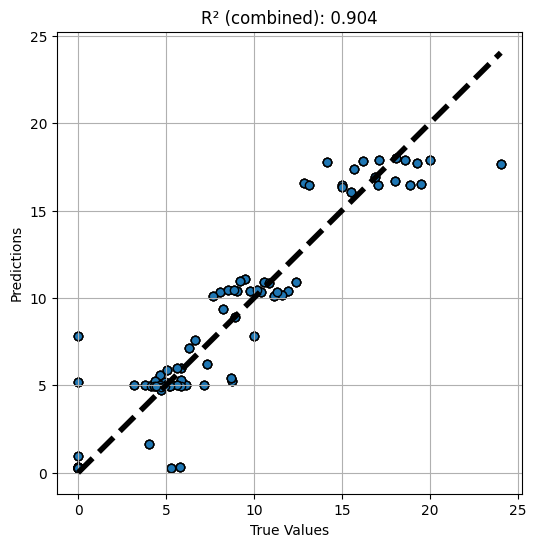

Combined R²: 0.9043537012274686


In [3]:
# 合并训练集和测试集
X_combined = np.vstack((X_train_scaled, X_test_scaled))
y_combined = np.hstack((y_train, y_test))

# 使用最佳模型进行预测
y_pred_combined = best_model.predict(X_combined)

# 计算合并数据集上的 R² 值
r2_combined = r2_score(y_combined, y_pred_combined)

# 绘制 R² 图
plt.figure(figsize=(6, 6))
plt.scatter(y_combined, y_pred_combined, edgecolors=(0, 0, 0))
plt.plot([min(y_combined), max(y_combined)], [min(y_combined), max(y_combined)], 'k--', lw=4)
plt.title(f'R² (combined): {r2_combined:.3f}')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

print(f'Combined R²: {r2_combined}')